In [21]:
# run database_creation.ipynb first

## Parallel AIS Data Processing Notebook
This notebook performs data insertion, noise filtering, and delta_t calculation for AIS data.

## Setup: Imports and Configuration

In [22]:
import pandas as pd
from tqdm import tqdm
from pymongo import MongoClient, ASCENDING
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

def get_client(port = 27017):
    return MongoClient('localhost', port, directConnection=True, replicaSet='myReplicaSet')

DB_NAME = 'ais_assignment_db_sequential'
RAW_COLLECTION_NAME = 'ais_raw_data_seq'
FILTERED_COLLECTION_NAME = 'ais_filtered_data_seq'

CSV_FILE_PATH = "aisdk_test.csv"
CHUNK_SIZE = 10000

main_client = get_client()
db = main_client[DB_NAME]

### Health check and pymongo functions

In [23]:
def print_member_status(client):
    db = client.admin
    rs_status = db.command({'replSetGetStatus': 1})

    for m in rs_status['members']:
        print(m['name'], m['stateStr'])

def ping(client):
    try:
        client.admin.command('ping')
        print("Ping successful")
    except Exception as e:
        print(f"Ping failed: {e}")

In [24]:
print_member_status(main_client)
ping(main_client)

mongo1:27017 SECONDARY
mongo2:27017 SECONDARY
mongo3:27017 PRIMARY
Ping successful


In [4]:
# df= pd.read_csv(CSV_FILE_PATH)
# df.head(1)
# df["Navigational status"].value_counts()

## Task 2: Data Insertion
Reading data from CSV and inserting into MongoDB. Timestamps are converted.

In [7]:
# Drop collection

raw_collection = db[RAW_COLLECTION_NAME]
raw_collection.drop()

In [10]:
import multiprocessing as mp

def insert_chunk(chunk_df, collection):
    chunk_df['# Timestamp'] = pd.to_datetime(chunk_df['# Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    chunk_df.dropna(subset=['# Timestamp'], inplace=True)
    records = chunk_df.to_dict(orient='records')
    if records:
        collection.insert_many(records, ordered=False)
        return len(records)
    return 0

# function for parallel processing
def process_chunk(chunk_df):
    process_client = get_client()
    process_db = process_client[DB_NAME]
    process_collection = process_db[RAW_COLLECTION_NAME]
    inserted_count = insert_chunk(chunk_df, process_collection)
    return inserted_count

num_processes = mp.cpu_count()
total_inserted = 0
chunks = pd.read_csv(CSV_FILE_PATH, chunksize=CHUNK_SIZE)
with mp.Pool(processes=num_processes) as pool:
    results = pool.imap_unordered(process_chunk, chunks)
    for i, result in enumerate(tqdm(results, total= int(1200000 / CHUNK_SIZE))):
        total_inserted += result
print(f"Total documents inserted: {total_inserted}")

 17%|█▋        | 20/120 [00:01<00:09, 10.25it/s]

Total documents inserted: 199999


In [11]:
# Create index
raw_collection.create_index([("MMSI", ASCENDING), ("# Timestamp", ASCENDING)])

'MMSI_1_# Timestamp_1'

In [12]:
print(raw_collection.count_documents({}))

199999


In [13]:
sorted(list(raw_collection.index_information()))

['MMSI_1_# Timestamp_1', '_id_']

## Task 3: Data Noise Filtering (Sequential)
Filtering noise from `ais_raw_data_seq` and storing in `ais_filtered_data_seq`.

In [14]:
# Identifying vessels with >= 100 data points

pipeline = [
    {'$group': {'_id': '$MMSI', 'count': {'$sum': 1}}},
    {'$match': {'count': {'$gte': 100}}}
]
mmsi_docs_to_process = list(raw_collection.aggregate(pipeline))
mmsis_to_filter = [doc['_id'] for doc in mmsi_docs_to_process]
print(f"Found {len(mmsis_to_filter)} vessels with >= 100 data points to filter.")

Found 749 vessels with >= 100 data points to filter.


In [15]:
filtered_collection = db[FILTERED_COLLECTION_NAME]
raw_collection = db[RAW_COLLECTION_NAME]

In [16]:
filtered_collection.drop()
print(filtered_collection.count_documents({}))

filtered_collection.create_index([("MMSI", ASCENDING), ("# Timestamp", ASCENDING)])

0


'MMSI_1_# Timestamp_1'

In [17]:
total_filtered_inserted = 0

required_fields = ['MMSI', 'Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']
nav_status_field = 'Navigational status'
invalid_nav_status = 'Unknown value'

def filter_vessel_data(vessel_data):
    filtered_points = []
    for point in vessel_data:
        is_valid_point = True
        for field in required_fields:
            value = point.get(field)
            if value is None or (isinstance(value, float) and np.isnan(value)):
                is_valid_point = False
                break
        if not is_valid_point: continue

        nav_status = point.get(nav_status_field)
        if nav_status is None or nav_status == invalid_nav_status:
            is_valid_point = False
        
        if is_valid_point:
            filtered_points.append(point)
    
    return filtered_points


def process_vessel_data(mmsi):
    process_client = get_client()
    process_db = process_client[DB_NAME]
    process_collection = process_db[RAW_COLLECTION_NAME]
    filtered_process_collection = process_db[FILTERED_COLLECTION_NAME]

    vessel_data = list(process_collection.find({'MMSI': mmsi}).sort('# Timestamp', ASCENDING))
    filtered_points_for_mmsi = filter_vessel_data(vessel_data)
    
    if filtered_points_for_mmsi:
        filtered_process_collection.insert_many(filtered_points_for_mmsi, ordered=False)
        return len(filtered_points_for_mmsi)
    return 0

with mp.Pool(processes=num_processes) as pool:
    results = tqdm(pool.imap_unordered(process_vessel_data, mmsis_to_filter), total=len(mmsis_to_filter))
    total_filtered_inserted = sum(results)

print(f"Total documents inserted in filtered collection: {total_filtered_inserted}")

100%|██████████| 749/749 [00:04<00:00, 173.76it/s]


Total documents inserted in filtered collection: 113342


In [18]:
print(raw_collection.count_documents({}))
print(filtered_collection.count_documents({}))

199999
113342


## Task 4: Calculation of Delta t and Histogram Generation (Sequential)
Calculating delta_t for vessels in `ais_filtered_data_seq` and generating a histogram.

In [19]:
all_delta_t_values = []
filtered_collection = db[FILTERED_COLLECTION_NAME]

distinct_mmsis_for_dt = filtered_collection.distinct('MMSI')
print(f"Found {len(distinct_mmsis_for_dt)} distinct MMSIs for delta_t.")

for i, mmsi in tqdm(enumerate(distinct_mmsis_for_dt), total=len(distinct_mmsis_for_dt), desc="Calculating delta_t"):
    vessel_data = list(filtered_collection.find({'MMSI': mmsi}).sort('# Timestamp', ASCENDING))
    delta_t_values_for_mmsi = []
    if len(vessel_data) > 1:
        for k in range(len(vessel_data) - 1):
            t1 = vessel_data[k]['# Timestamp']
            t2 = vessel_data[k+1]['# Timestamp']
            if isinstance(t1, datetime) and isinstance(t2, datetime):
                delta = (t2 - t1).total_seconds() * 1000 # milliseconds
                if delta >= 0: # Ensure non-negative delta_t
                        delta_t_values_for_mmsi.append(delta)
            else:
                print(f"Warning: Non-datetime object for MMSI {mmsi}, index {k}. t1:{type(t1)}, t2:{type(t2)}")
    all_delta_t_values.extend(delta_t_values_for_mmsi)

    # print(f"Delta_t for MMSI {i+1}/{len(distinct_mmsis_for_dt)} ({mmsi}). Found {len(delta_t_values_for_mmsi)} values.")

print(f"Total delta_t values collected: {len(all_delta_t_values)}")

Found 594 distinct MMSIs for delta_t.


Calculating delta_t: 100%|██████████| 594/594 [00:01<00:00, 517.31it/s]

Total delta_t values collected: 112748


Delta_t stats (ms): Min: 1000.00, Max: 300000.00, Mean: 9456.24, Median: 10000.00


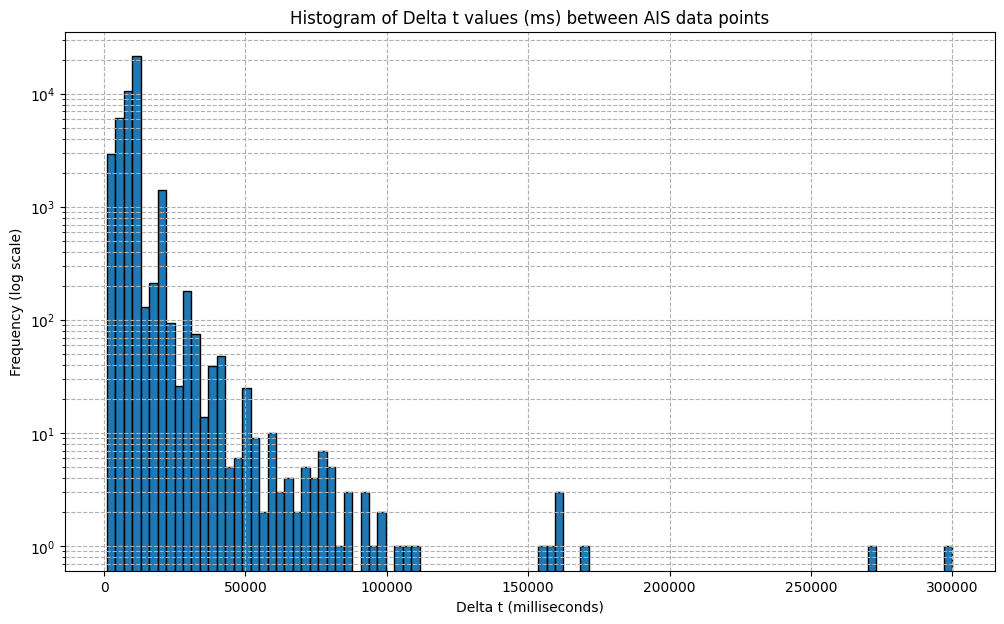

In [20]:
plt.figure(figsize=(12, 7))

positive_delta_t = [dt for dt in all_delta_t_values if dt > 0] 

plt.hist(positive_delta_t, bins=100, edgecolor='black')
plt.yscale('log', nonpositive='clip')
plt.title('Histogram of Delta t values (ms) between AIS data points')
print(f"Delta_t stats (ms): Min: {np.min(positive_delta_t):.2f}, Max: {np.max(positive_delta_t):.2f}, Mean: {np.mean(positive_delta_t):.2f}, Median: {np.median(positive_delta_t):.2f}")

plt.xlabel('Delta t (milliseconds)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", linestyle='--')
plt.show()

In [ ]:
main_client.close() 